In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from itertools import product
from alibi.confidence.model_linearity import linearity_measure, LinearityMeasure

Using TensorFlow backend.


# Dataset

In [2]:
ds = load_iris()
X_train, y_train = ds.data[:, :2], ds.target

# Models

In [3]:
lr = LogisticRegression(fit_intercept=False, multi_class='multinomial', solver='newton-cg')
rf = RandomForestClassifier(n_estimators=10)
xgb = XGBClassifier()
svm = SVC(gamma=.1, kernel='rbf', probability=True)

In [18]:
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Decision boundaries and linearity 

### Logistic regression

In [19]:
# Creating grid
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

In [20]:
lm = LinearityMeasure()
lm.fit(X_train)

In [21]:
clf = lr
predict_fn = lambda x: clf.predict_proba(x)

In [22]:
L = np.empty(shape=(xx.shape[0], xx.shape[1]))
count = 0
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        if count % 1000 == 0:
            print('point ', count)
        idx = (i * xx.shape[1]) + j
        L[i, j] = lm.linearity_measure(predict_fn, np.array([xx[i,j], yy[i,j]]))
        count += 1

point  0
point  1000
point  2000


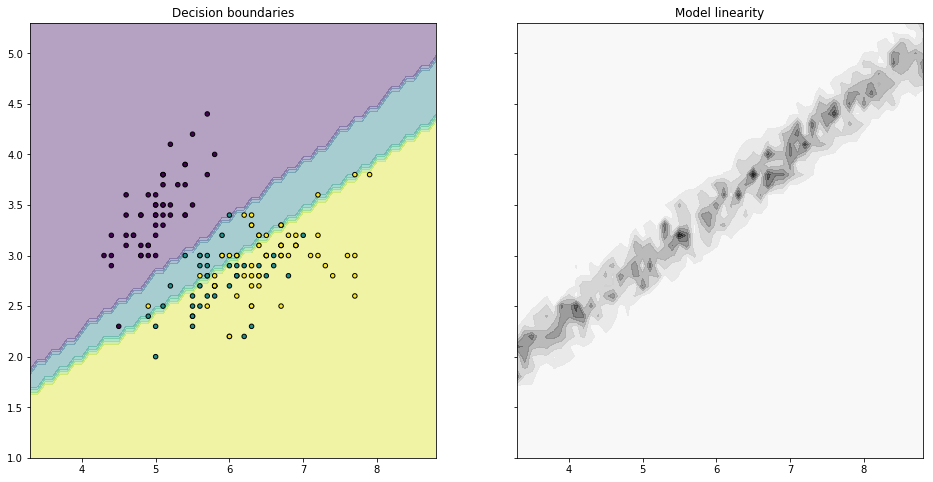

In [23]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries')

#axarr[1].contourf(xx, yy, Z, alpha=0.4)
#axarr[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k',alpha=1)
axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('Model linearity')
plt.show()